<a href="https://colab.research.google.com/github/tikendraw/caption-generator/blob/main/captiongenerator_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caption Generator


In [1]:
# Dependencies
import numpy as np
import pandas as pd
import os, random, math
import tensorflow as tf
import glob
import shutil
from zipfile import ZipFile
import datetime
import sys

if not os.path.exists('funcyou'):
	! git clone https://github.com/tikendraw/funcyou -q

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tqdm import tqdm
from pathlib import Path
# from test_functions import count_files_by_type
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import pad_sequences
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from collections import Counter

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocessing
from tensorflow.keras.layers import (
    TextVectorization, Embedding, LSTM, GRU, Bidirectional, TimeDistributed, Dense, Attention, MultiHeadAttention, Flatten, Dropout,
    Concatenate, Activation, GlobalAveragePooling2D
    )
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.utils import array_to_img, img_to_array
import string
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

In [2]:
# !pip install numba -q

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()


In [3]:
GPU = tf.config.list_physical_devices('GPU')
print(len(GPU))


1


In [4]:
# Set a seed value
seed_value = 12321

os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

# tf.set_random_seed(seed_value)


In [5]:
IMG_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 5
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)


## Downloading Dataset


In [6]:
dataset_url = Path(
    'https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset')
api_command = "kaggle datasets download -d hsankesara/flickr-image-dataset"


In [7]:
image_dir = Path('./input/flickr30k/images')
dest_caption_file_dir = Path('./input/flickr30k/results.csv')


In [8]:
def download_kaggle_dataset(api_command):
    if 'google.colab' in str(get_ipython()):

        print('Installing Kaggle...')
        !pip install kaggle - q

        if 'kaggle.json' in os.listdir():
            try:
                os.makedirs('/root/.kaggle', exist_ok=True)
                os.system('cp kaggle.json /root/.kaggle/kaggle.json')
                os.system('! chmod 600 /root/.kaggle/kaggle.json')

                print('Downloading...')
                os.system(api_command)

                print('Downloaded')

            except Exception as e:
                raise e

        else:
            raise FileNotFoundError('Keep "kaggle.json" in current directory')


In [9]:
!pip install funcyou/.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./funcyou
  Preparing metadata (setup.py) ... done
  Created wheel for funcyou: filename=funcyou-1.0.0-py3-none-any.whl size=1017 sha256=c8f50bb0c2d7d7235da4a3b60497cd436b370dee1d6bef5f864860d1d82aaa3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-g5k_m6hi/wheels/4c/2d/69/bdbe003124e0474654284a1b1c4db88f78b16c105cbbdccca0
Successfully built funcyou


In [10]:

# from funcyou.utils import dir_walk

# dir_walk('.')


In [11]:
def move_to_dest():
    # copying photos to destination directory
    src_dir = "./flickr30k_images/flickr30k_images/flickr30k_images/"
    dst_dir = "./input/flickr30k/images"
    os.makedirs(dst_dir, exist_ok=True)
    # Use glob to find all files in the source directory
    files = glob.glob(f"{src_dir}*")

    # Iterate over all files found by glob
    for file in files:
        # Extract the filename from the full file path
        filename = file.split("/")[-1]
        # Construct the full path of the destination file
        dst_path = f"{dst_dir}/{filename}"
        # Copy the file from source to destination
        shutil.copy(file, dst_path)

    # copying captionfile
    src_caption_file_dir = Path(
        "./flickr30k_images/flickr30k_images/results.csv")
    shutil.copy(src_caption_file_dir, dest_caption_file_dir)


In [12]:
if 'google.colab' in str(get_ipython()):

    from google.colab import drive
    drive.mount('/content/drive')
    # Downloading dataset
    download_kaggle_dataset(api_command)

    # Extracting dataset zip
    with ZipFile('flickr-image-dataset.zip') as zip:
        zip.extractall()

    # Moving this to place
    print('Moving...')
    move_to_dest()
    print('Done')


Mounted at /content/drive
Installing Kaggle...
ERROR: Invalid requirement: '-'
Downloading...
Downloaded
Moving...
Done


In [13]:
# delete the folder to save space
# os.system('rm -rf flickr30k_image*')
# os.system('rm -rf input')


# Reading and Visualizing Image Dataset


In [14]:
image_dir = Path('./input/flickr30k/images')
caption_file = Path('input/flickr30k/results.csv')


In [15]:
df = pd.read_csv(dest_caption_file_dir, delimiter='|', on_bad_lines='skip')

# lowring and striping column names
df.columns = df.columns.str.lower().str.strip()

print('shape: ', df.shape)
df.head()


shape:  (158915, 3)


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [16]:
# Check for null values
df.isnull().sum()


image_name        0
comment_number    0
comment           1
dtype: int64

In [17]:
# dropping nulls
df.dropna(inplace=True)


In [18]:
df['serial'] = LabelEncoder().fit_transform(df['image_name'])


In [19]:
df.head(20)


,image_name,comment_number,comment,serial
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,0
1,1000092795.jpg,1,"Two young , White males are outside near many...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0
5,10002456.jpg,0,Several men in hard hats are operating a gian...,1
6,10002456.jpg,1,Workers look down from up above on a piece of...,1
7,10002456.jpg,2,Two men working on a machine wearing hard hats .,1
8,10002456.jpg,3,Four men on top of a tall structure .,1
9,10002456.jpg,4,Three men on a large rig .,1


In [20]:
print('Total images: ', df['image_name'].nunique())
print('Total images: ', df['serial'].max())


Total images:  31783
Total images:  31782


In [21]:
counts = Counter(df['image_name'])
print(np.bincount(list(counts.values())))

del(counts)


[    0     0     0     0     1 31782]


THis shows 1 photo has 4 captions while rest(31782) have 5 captions


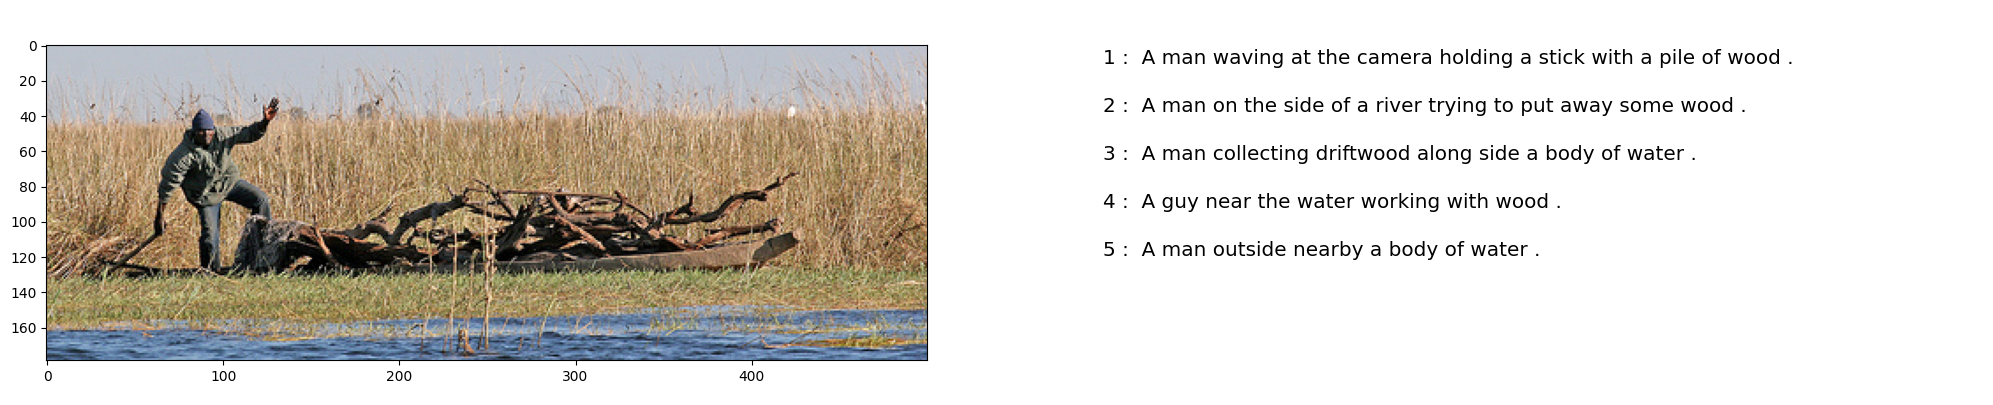

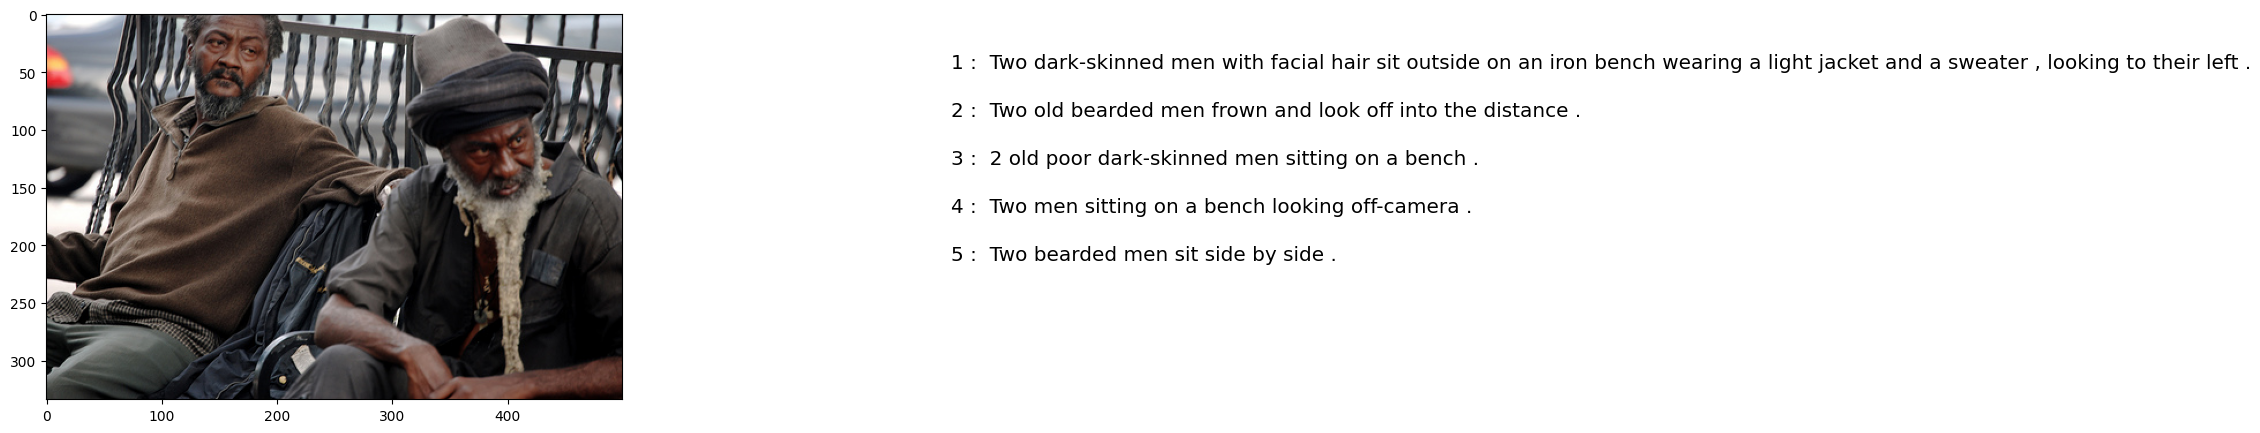

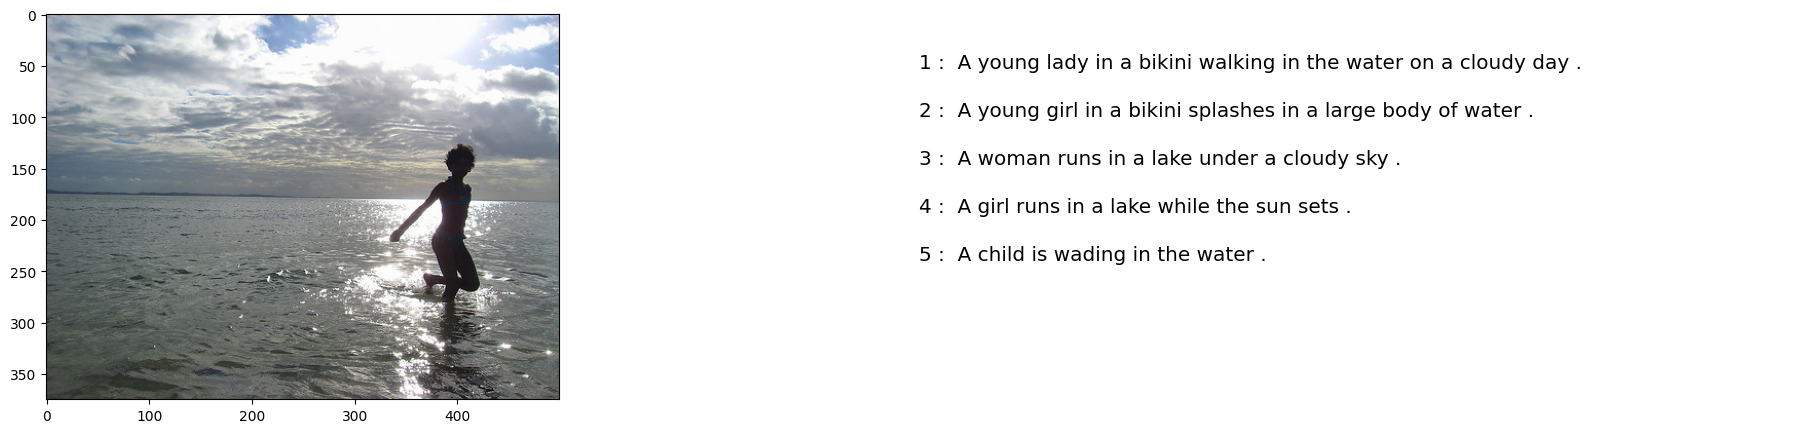

In [22]:
# Visualizing
def plot_image_with_captions(df, n: int = 3):
    for _ in range(n):
        sample_image_name = df['image_name'].sample(1).values[0]

        # Reading image
        sample_path = os.path.join(image_dir, sample_image_name)
        fig = plt.figure(figsize=(25, 5))
        ax = fig.add_subplot(1, 2, 1)
        image = plt.imread(sample_path)
        plt.imshow(image)

        # captions
        all_captions = df[df['image_name'] == sample_image_name]['comment']
        ax = fig.add_subplot(1, 2, 2)
        plt.axis('off')
        for num, caption in enumerate(all_captions.values):
            caption = f'{num+1} : {caption}'
            ax.text(0, 0.85 - num*(1/8), caption, horizontalalignment='left', verticalalignment='bottom',
                    multialignment='left', fontsize='x-large', transform=ax.transAxes)


a = plot_image_with_captions(df)


# Text preprocessing


In [23]:

START_TOKEN = 'startseq'
END_TOKEN = 'endseq'


In [24]:
df.head()

,image_name,comment_number,comment,serial
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...,0
1,1000092795.jpg,1,"Two young , White males are outside near many...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [25]:
df['comment'] = START_TOKEN + ' ' + df['comment'] + ' ' + END_TOKEN


In [26]:
import regex as re

def preprocess_text(text):

    text = tf.strings.lower(text)

    text = tf.strings.regex_replace(text, r'\d', '')

    # Remove any punctuations
    text = tf.strings.regex_replace(text, '[%s]' % re.escape(
        '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

    # Remove single characters
    text = tf.strings.regex_replace(text, r'\b\w\b', '')
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿|]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    # text = tf.strings.join([START_TOKEN, text, END_TOKEN], separator=' ')
    return text


text = ["Hello, world! This is an 😊 example 123."]
preprocessed_text = preprocess_text(text)
print(preprocessed_text.numpy()[0].decode())


hello world this is an  example


## Tokenization


max:  84
mean:  15.389418175868709
median:  14.0
std : 5.421043307660759
47.0 words covers 99.9% of the data


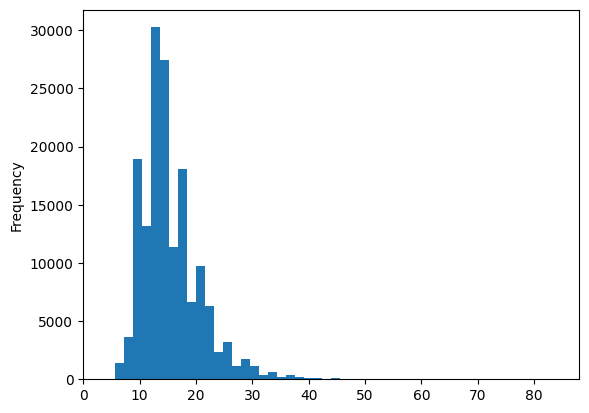

In [27]:
df['word_count'] = df['comment'].apply(lambda x: len(str(x).split()))
print('max: ', df['word_count'].max())  # 82
print('mean: ', df['word_count'].mean())
print('median: ', df['word_count'].median())
print('std :', df['word_count'].std())
df['word_count'].plot(kind='hist', bins=50)

# how much precenatage of 50 words covers
percent = 99.9
print(
    f"{np.percentile(df['word_count'], 99.9)} words covers {percent}% of the data")
# 45 token length covers 99.9 % data while 82 token length covers 100 %
# that is alot of tokens just to cover .1%
# so we will go with max_token 50
max_len = 50


In [28]:
tokenizer = TextVectorization(
    standardize=preprocess_text)

'''
max_len +1 beacause later while mapping we will shift y_in, and y_out by one word so the max_len will be 50
 else it would be 49 throw error for not matchin shapes
'''

tokenizer.adapt(df['comment'])


In [29]:
# Lookup Table
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=tokenizer.get_vocabulary(), mask_token='', oov_token='[UNK]')
id_to_word = tf.keras.layers.StringLookup(vocabulary=tokenizer.get_vocabulary(
), mask_token='', oov_token='[UNK]', invert=True)


In [30]:
print('Total words: ', tokenizer.vocabulary_size())

print('least frequent words: \n')
print(*tokenizer.get_vocabulary()[-150:], '\n')

print('Most frequent words: \n')
print(*tokenizer.get_vocabulary()[:150])


Total words:  19751
least frequent words: 

alterations alsosleeping alright alpha alpacas alotment aloof alon almostpristine almostfull almostempty almostdried allwomen allwoman allure allude alloy allot allmale allianz allblue allblack aligator alienlike alfresco alfalfa alessi alertly alerting albino alb alarmedly alabama airwoman airtraffic airman airlifted airgame airforce aircrew airborn aimlessly aikido ahole ahmadinejad ah agriculture agreement agitate aghast aggresively aggitates agents agenda agency agains againest aft afroamerican afloat afl afican afghanistan afghanhound affluently affixing affiliate affectionate affecting affairs aerodynamically aerobic aerobatics aerobatic aerially advocate advisement advise advertizing advertisment advertisers advert adversary adventurously adventuring adventures advancing advanced adultsized adultsize adulthood adorns adornments adopts admitted admits admission administrators administering adequately adeleide addressed addiction addicte

# Image Preprocessing


# Resnet and Efficientnet


In [31]:
# # Downloading CNN models
# eff = tf.keras.applications.EfficientNetB6(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE),
# 	)

# eff.trainable = False


resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=IMG_SHAPE)

)

resnet.trainable = False


94668760/94668760 [==============================] - 1s 0us/step


In [32]:
# Creating filepath to image
df['image_path'] = str(image_dir) + '/' + df['image_name']


In [33]:
df.head()
# df.image_path.sample(3).values


,image_name,comment_number,comment,serial,word_count,image_path
0,1000092795.jpg,0,startseq Two young guys with shaggy hair look...,0,19,input/flickr30k/images/1000092795.jpg
1,1000092795.jpg,1,"startseq Two young , White males are outside ...",0,13,input/flickr30k/images/1000092795.jpg
2,1000092795.jpg,2,startseq Two men in green shirts are standing...,0,13,input/flickr30k/images/1000092795.jpg
3,1000092795.jpg,3,startseq A man in a blue shirt standing in a ...,0,13,input/flickr30k/images/1000092795.jpg
4,1000092795.jpg,4,startseq Two friends enjoy time spent togethe...,0,9,input/flickr30k/images/1000092795.jpg


In [34]:

@tf.function
def load_images_now(x):
    image_data = tf.io.read_file(x)
    image_features = tf.image.decode_jpeg(image_data, channels=CHANNELS)
    image_features = tf.image.resize_with_pad(
        image_features, target_height=IMG_SIZE, target_width=IMG_SIZE)
    image_features = tf.keras.applications.resnet.preprocess_input(
        image_features)
    image_features = tf.reshape(
        image_features, (1, IMG_SIZE, IMG_SIZE, CHANNELS))
    image_features = resnet(image_features)
    image_features = GlobalAveragePooling2D()(image_features)
    image_features = tf.squeeze(image_features)

    # (2048, ) remember the shape this would be input shape for image input
    return image_features


# Making dataset


In [35]:
TRAIN_SIZE = .05
TEST_SIZE = .02
VAL_SIZE = .001

train, val = train_test_split(
    df[['image_path', 'comment']], train_size = TRAIN_SIZE, test_size=VAL_SIZE, random_state=11)
train, test = train_test_split(
    train[['image_path', 'comment']],  test_size=TEST_SIZE, random_state=11)


In [36]:
# print(f'{train.shape=}')
# print(f'{test.shape=}')
# print(f'{val.shape=}')

In [37]:
train_data = tf.data.Dataset.from_tensor_slices(
    (train.image_path, train.comment))
test_data = tf.data.Dataset.from_tensor_slices((test.image_path, test.comment))
val_data = tf.data.Dataset.from_tensor_slices((val.image_path, val.comment))


In [38]:
# for i, j in train_data.take(10):
#     print(f'{i.numpy().decode():<40} {j.numpy()}')


In [39]:
# This function loads image from given filepath ,
# tokenizes caption and arranges in y_in and y_out
def mapper(x, y):
    x = load_images_now(x)
    y = tokenizer(y)
    
    
    y_in = y[:-1]
    y_in =  tf.pad(y_in, [[1, max_len-1 - tf.shape(y_in)[0]]] , constant_values=0)

    y_out = y[1:]
    y_out =  tf.pad(y_out, [[1, max_len-1 - tf.shape(y_out)[0]]], constant_values=0)

    return (x, y_in), y_out


In [40]:
train_data = train_data.map(mapper)


In [41]:
for (img_in, txt_in), txt_out in train_data.take(3):
    # print(f'{i.numpy().decode():<40} {j.numpy()}')
    print('x     : ', img_in.shape)
    print('y_in  : ', txt_in)
    print('y_out : ', txt_out)
    print('\n')


x     :  (2048,)
y_in  :  tf.Tensor(
[    0     2   773  5422   136 10581     6  1445    17   576     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int64)
y_out :  tf.Tensor(
[    0   773  5422   136 10581     6  1445    17   576     3     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0], shape=(50,), dtype=int64)


x     :  (2048,)
y_in  :  tf.Tensor(
[   0    2   13   20  165 1154   40  274 2327    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0

In [42]:
resnet_output_flattened_shape = 8*8*2048


In [43]:
txt_in

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([  0,   2,  28, 352,  24,  31, 575, 198,  87,  39, 151,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [44]:
# batching and prefetching
train_data = train_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(mapper).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(mapper).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


In [45]:
print("Number of training samples: %d" %
      tf.data.experimental.cardinality(train_data))
print("Number of validation samples: %d" %
      tf.data.experimental.cardinality(val_data))
print("Number of test samples: %d" %
      tf.data.experimental.cardinality(test_data))


Number of training samples: 974
Number of validation samples: 20
Number of test samples: 20


# Helper Functions


In [46]:
# from funcyou.callbacks import create_model_checkpoint
def create_model_checkpoint(model_name, save_dir, monitor: str = 'val_loss', verbose: int = 0, save_best_only: bool = True, save_weights_only: bool = False,
                            mode: str = 'auto', save_freq='epoch', options=None, initial_value_threshold=None, **kwargs):
    # sourcery skip: avoid-builtin-shadow
    model_name = f'{model_name}-{str(datetime.datetime.now())}'
    dir = os.path.join(save_dir, model_name)

    if not os.path.exists(dir):
        os.makedirs(dir)

    return tf.keras.callbacks.ModelCheckpoint(
        dir,
        monitor=monitor,
        verbose=verbose,
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        save_freq=save_freq,
        options=options,
        initial_value_threshold=initial_value_threshold,
        **kwargs)


## Clearing memory before running the model to free some ram


In [47]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key=lambda x: -x[1],)[:15]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                            df: 58.5 MiB
                         train:  1.8 MiB
                           val: 37.4 KiB
                          test: 36.9 KiB
                           _19:  5.0 KiB
                          _i26:  3.5 KiB
                            __:  1.8 KiB
                           _33:  1.8 KiB
                       ZipFile:  1.4 KiB
                           _15:  1.3 KiB
                           _i1:  1.3 KiB
                           ___:  1.3 KiB
                           _24:  1.3 KiB
                          tqdm:  1.0 KiB
                  LabelEncoder:  1.0 KiB


In [48]:
# del(df, train, val, counts, test)


# Model


In [49]:
# write a funtion that creates a model that takes and image, and text  then pre processes it with resnet_preprocess funtion then extracts freature using resnet mdoel then calculates attention with text after
# lstm and return output

UNITS = 32
VOCAB_SIZE = tokenizer.vocabulary_size()


def get_model():

    embdding_layer = Embedding(
        input_dim=VOCAB_SIZE, output_dim=UNITS, input_length=max_len, mask_zero=True)
    encoder = LSTM(UNITS, return_sequences=True, return_state=True)
    decoder = LSTM(UNITS, return_sequences=True, return_state=True)

    # image inputs
    image_input = Input(shape=(2048, ))
    print(image_input.shape)

    x = Dense(UNITS*max_len)(image_input)
    # print('dense: ',x.shape)

    x = tf.reshape(x, (-1, max_len, UNITS))
    # print('reshape: ',x.shape)
    img_model = keras.Model(inputs=image_input, outputs=x)

    # print('')

    # text inputs
    txt_input = Input(shape=(max_len,))
    # print('text_input: ',text_input.shape)

    i = embdding_layer(txt_input)
    # print('embedding: ',i.shape)

    i, j, k = encoder(i)

    i = Dropout(.3)(i)
    
    i, _, _ = decoder(i, initial_state=[j, k])
    
    i = Dropout(.3)(i)
    # print('i:', i.shape)

    #  attention between x and i
    l = Attention()([x, i])
    ll = Attention()([i, x])
    # print('attentions: ',l.shape, ll.shape)

    #  concatnate x and i
    m = Concatenate()([x, i, l, ll])
    # print('concat attention: ',m.shape)

    m = Dropout(.3)(m)

    m = Dense(VOCAB_SIZE)(m)
    # print('dense out: ',m.shape)

    m = Activation('softmax')(m)

    return keras.Model(inputs=[img_model.input, txt_input], outputs=m), img_model

1
get_model()


(None, 2048)


(<keras.engine.functional.Functional at 0x7f9e664a97e0>,
 <keras.engine.functional.Functional at 0x7f9e66efd150>)

In [50]:
model, img_model = get_model()
print(model.summary(), img_model.summary())

(None, 2048)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 32)       632032      ['input_5[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 50, 32),     8320        ['embedding_1[0][0]']            
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                               

## Metrics and Loss


In [51]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)


In [52]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)


In [53]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

os.makedirs('log', exist_ok=True)
csv_logger = CSVLogger('./log/training.log')


In [54]:
EPOCHS = 5
int(.1*(len(train_data) / EPOCHS)), int(0.5*(len(val_data) / EPOCHS))


(19, 2)

## Fitting the Model


In [55]:
# #fit the model
history = model.fit(train_data,
                    epochs=EPOCHS,
                    validation_data=val_data,
                    steps_per_epoch=int(.01*(len(train_data) / EPOCHS)),
                    validation_steps=int(0.2*(len(val_data) / EPOCHS)),
                    callbacks=[
                        csv_logger
                    ]
                    )


Epoch 1/5
1/1 [==============================] - 20s 20s/step - loss: 156.6789 - masked_acc: 0.0000e+00 - masked_loss: 156.6789
Epoch 2/5
1/1 [==============================] - 2s 2s/step - loss: 384.2819 - masked_acc: 0.0000e+00 - masked_loss: 384.2820
Epoch 3/5
1/1 [==============================] - 2s 2s/step - loss: 440.2453 - masked_acc: 0.0000e+00 - masked_loss: 440.2453
Epoch 4/5
1/1 [==============================] - 2s 2s/step - loss: 535.6393 - masked_acc: 0.0000e+00 - masked_loss: 535.6392
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 587.2258 - masked_acc: 0.0488 - masked_loss: 587.2258


In [56]:
!pwd


/content


In [57]:
# model.save(f'/content/drive/MyDrive/caption_generator/{EPOCHS}.h5')
# model.load_weights(f'/content/drive/MyDrive/caption_generator/{EPOCHS}.h5')


In [58]:
ypred2 = tf.squeeze(tf.round(model.predict(test_data,
                                           use_multiprocessing=True)))
print('ypred2.shape: ', ypred2.shape)

ytest_true = [y for x, y in test_data.unbatch()]
print('ypred2.shape: ', len(ytest_true))


20/20 [==============================] - 37s 2s/step
ypred2.shape:  (159, 50, 19751)
ypred2.shape:  159


In [59]:
yy = tf.argmax(ypred2, axis=-1)


In [60]:
yy.shape


TensorShape([159, 50])

In [61]:
yy


<tf.Tensor: shape=(159, 50), dtype=int64, numpy=
array([[11559,    12,     9, ...,   154,  8139,   433],
       [11559,    12,     9, ...,   154,  8139,   433],
       [11559,    12,     9, ...,   154,  8139,   433],
       ...,
       [ 8016,    12,     9, ...,   154, 12186,   433],
       [11559,    13,     9, ...,   154,  8139,   433],
       [11559,    12,     9, ...,   154,  8139,   433]])>

# Prediction


In [62]:
def tokens_to_text(tokens):
    words = id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, f'^ *{START_TOKEN} *', '')
    result = tf.strings.regex_replace(result, f' *{END_TOKEN} *$', '')
    return result


In [63]:
random_image_path = test.image_path.sample(1).values[0]
random_image_path

'input/flickr30k/images/3285298241.jpg'

In [64]:
start_token = word_to_id('startseq') #2
end_token = word_to_id('endseq') #3

In [65]:
def create_initial_input(max_len):

    # Get the word index of the word `startseq`.
    start_token = word_to_id('startseq')

    # Create a list of zeros of length `max_len`.
    initial_input = [0] * max_len

    # Set the first element of the list to the word index of the word `startseq`.
    initial_input[0] = start_token.numpy()

    initial_input = tf.reshape(initial_input,(max_len,))
    return initial_input

In [123]:
def generate_caption(image_path, model, tokenizer):

    # Load the image and extract its features using the ResNet model.
    features = load_images_now(image_path)
    features = tf.reshape(features, (1, features.shape[0]))

    # Generate a caption using the model.
    start_token_id = word_to_id('startseq').numpy()
    start_token = 'startseq'
    end_token_id = word_to_id('endseq')
    end_token = 'endseq'

    
    caption_list = [start_token, 'hello']
    caption = ' '.join(caption_list)
    # caption.append(start_token)

    sequence = tokenizer(caption)
    sequence = tf.pad(sequence, [[0, max_len-tf.shape(sequence)[0]]])
    sequence = tf.reshape(sequence, (1, max_len))

    print(features.shape, sequence.shape)

    # x = layers.Concatenate()([features, sequence])
    # print(x.shape)
    # yy = model.predict((features, sequence))
    # print(yy.shape)
    for i in range(2):
        # Get the next word from the model.
        next_word_idx = model.predict([features, sequence])
        
        print(next_word_idx.shape)
        print(next_word_idx)

    #     # If the next word is the end token, stop generating.
    #     if next_word_idx == end_token_id:
    #         break

    #     # Add the next word to the caption.
    #     caption_list.append(next_word_idx)

    # # Convert the caption from a list of indices to a string.
    # caption = tokenizer.decode(caption)

    # return caption, sequence
    # # return tokens_to_text(caption)

In [124]:
# create_initial_input(max_len)
generate_caption(random_image_path, model, tokenizer)

(1, 2048) (1, 50)
1/1 [==============================] - 4s 4s/step
(1, 50, 19751)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
1/1 [==============================] - 0s 37ms/step
(1, 50, 19751)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [114]:
for (img, txt_in), txt_out in train_data.unbatch():
    print(img.shape)
    print(txt_in.shape)
    print(txt_out.shape)
    break

(2048,)
(50,)
(50,)
